In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../AAPL_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-06,16.929031,17.018355,16.607525,16.727351,412610800
2014-01-07,16.807955,16.992205,16.741973,16.941163,317209200
2014-01-08,16.914400,16.979759,16.765941,16.769674,258529600
2014-01-09,16.698412,17.020229,16.661997,17.018361,279148800
2014-01-10,16.586985,16.831616,16.530028,16.801425,304976000
...,...,...,...,...,...
2023-12-22,192.444580,194.243775,191.818335,194.015137,37122800
2023-12-26,191.897888,192.732871,191.679200,192.454544,28919300
2023-12-27,191.997253,192.345171,189.949550,191.341204,48087700


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]

(2514, 4)
torch.Size([1991, 10, 4])


4

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers)
        
    def forward(self, x):
        # x: input batch data, size: [input_seq_len, batch_size, feature_size]
        output, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(output_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        """
        x size = [batch_size, feature_size]
        --> x only has two dimensions since the input is batch of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        x = x.unsqueeze(0)  # -->[1, batch_size, feature_size]
        
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.linear(output)

        return prediction, hidden, cell    

In [5]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        x = x.permute(1,0,2) #我們的 dataloader是 [batch, seq,dim]
        y = y.permute(1,0,2) #但為了方便操作LSTM，直接把它擺成[seq,batch,dim]，output再把它擺回來
        """
        x = [input_seq_len, batch_size, feature_size]
        y = [target_seq_len, batch_size, feature_size]
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]
        
        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(y.shape).to(self.device) 
        
        hidden, cell = self.encoder(x)
        decoder_input = x[-1, :, :] # first input to decoder is last of x
        
        for i in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # place predictions in a tensor holding predictions for each time step
            outputs[i] = torch.squeeze(output,0)
            
            teacher_forcing = random.random() < teacher_forcing_ratio
            # output is the same shape as decorder input-->[batch_size, feature_size]
            # so we use output directly as input or use true lable depending on teacher_forcing flag
            decoder_input = y[i] if teacher_forcing else torch.squeeze(output,0)
        
        return outputs.permute(1,0,2)

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
encoder = Encoder(input_size=4, hidden_size=128).to(device)
decoder = Decoder(output_size=4, hidden_size=128).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [23]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "seq_lstm_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Model saved with val_loss: 0.0100
Epoch [1/100], Train Loss: 0.0045, Val Loss: 0.0100
Epoch [2/100], Train Loss: 0.0442, Val Loss: 0.0120
Epoch [3/100], Train Loss: 0.0785, Val Loss: 0.3235
Epoch [4/100], Train Loss: 0.0436, Val Loss: 0.1179
Epoch [5/100], Train Loss: 0.0242, Val Loss: 0.0409
Model saved with val_loss: 0.0092
Epoch [6/100], Train Loss: 0.0157, Val Loss: 0.0092
Epoch [7/100], Train Loss: 0.0078, Val Loss: 0.0094
Model saved with val_loss: 0.0032
Epoch [8/100], Train Loss: 0.0018, Val Loss: 0.0032
Epoch [9/100], Train Loss: 0.0028, Val Loss: 0.0044
Epoch [10/100], Train Loss: 0.0038, Val Loss: 0.0051
Model saved with val_loss: 0.0025
Epoch [11/100], Train Loss: 0.0050, Val Loss: 0.0025
Epoch [12/100], Train Loss: 0.0045, Val Loss: 0.0115
Epoch [13/100], Train Loss: 0.0035, Val Loss: 0.0336
Epoch [14/100], Train Loss: 0.0015, Val Loss: 0.0101
Epoch [15/100], Train Loss: 0.0036, Val Loss: 0.0037
Epoch [16/100], Train Loss: 0.0040, Val Loss: 0.0080
Epoch [17/100], Train Los

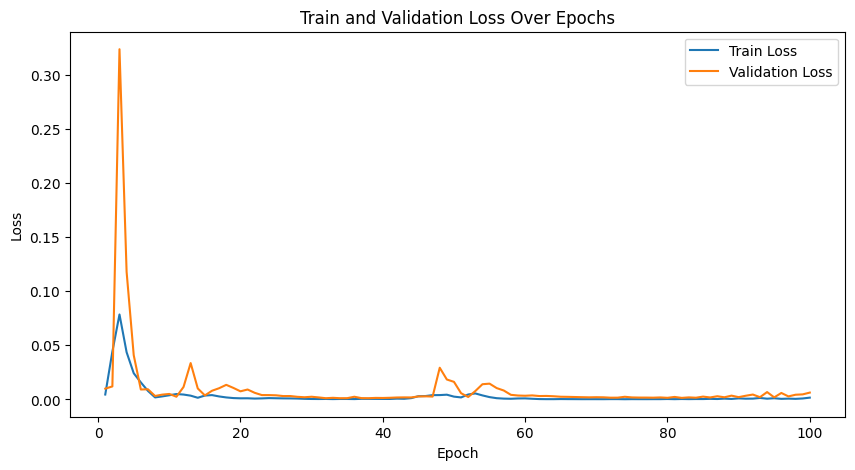

In [24]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

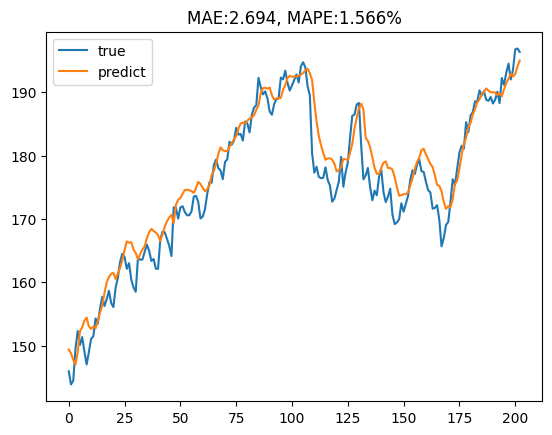

In [25]:
import matplotlib.pyplot as plt
close_price_true = []
close_price_pred = []
model = torch.load('seq_lstm_10.pth')
model.to(device)

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}%'.format(mae, mape*100))
plt.legend(['true', 'predict'])

In [26]:
close_price_true = []
close_price_pred = []

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
print("mape: ", mape)
print("mae: ", mae)

(203, 10)
(203, 10)
mape:  0.026742566472616962
mae:  4.799401318045343
